### Lab week 6 (Feb 8th – Feb 12th)

One issue in natural language processing is the identification of sentiment of texts, are they positive,
negative or neutral to some concept. This dataset
(https://github.com/thanhtut/info284_lab/blob/master/assignment1/twitter-airlinesentiment/Tweets.csv) has a collection of tweets about airlines with corresponding sentiments
(negative, positive, neutral).

The task we want you to do is to run three machine learning models using Naïve Bayes on the tweet
texts.
1. Prepare the data for machine learning. Extract the relevant columns, do language
preprocessing of the tweets, etc.
2. Run a BernoulliNB to classify sentiment
3. Run a MultiomialNB to classify sentiment
4. Run a MultinomialNB to classify sentiment, but instead of using a count vector you should
use a TF-IDF-vector for each instance. 

What is TF-IDF? Read sources on information retrieval,
and also look here: https://stackabuse.com/text-classification-with-python-and-scikit-learn/

How do the three approaches compare?

## Working with text data in scikit-learn
 https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Exploratory data analysis
https://www.kaggle.com/parthsharma5795/comprehensive-twitter-airline-sentiment-analysis

## Data analysis and data cleaning
https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
df['text'][9]

"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."

In [5]:
print("Shape of the dataframe is",df.shape)
print("The number of nulls in each column are \n", df.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [6]:
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [8]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

### 1. Prepare the data for machine learning. Extract the relevant columns, do language preprocessing of the tweets, etc.
Clean text data: https://stackabuse.com/text-classification-with-python-and-scikit-learn/

Preprocessing using CountVectorizer: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Train test split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

#### 1) Clean text data

If you don't have nltk or emoji installed, run: 

!pip install emoji

!pip install nltk

in an empty cell

In [12]:
df['negativereason'] = df['negativereason'].fillna("")


In [13]:
import re
import emoji
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

df['text'] = df['text'].map(lambda x: cleaner(x))
df['negativereason'] = df['negativereason'].map(lambda x: cleaner(x))

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


#### 2) Apply CountVectorizer to the text data
Read more about min_df and max_df parameters here: https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer

In [40]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X= vectorizer.fit_transform(df['text']).toarray()

#### 3) Select target values

In [41]:
y = df['airline_sentiment']
y.head()

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object

#### 4) Train test split 

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Run a BernoulliNB to classify sentiment
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html

#### 1) Import BernoulliNB and fit to training data

In [43]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)

BernoulliNB()

#### 2) Return predicted target values for X_test

In [44]:
y_pred = clf.predict(X_test)

#### 3) Get test set score

In [45]:
clf.score(X_test, y_test)

0.7691256830601093

#### 4) Classification report

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,
                            target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.86      0.84      0.85      1889
     neutral       0.55      0.61      0.58       580
    positive       0.70      0.67      0.68       459

    accuracy                           0.77      2928
   macro avg       0.70      0.71      0.70      2928
weighted avg       0.78      0.77      0.77      2928



negative    1889
neutral      580
positive     459
Name: airline_sentiment, dtype: int64


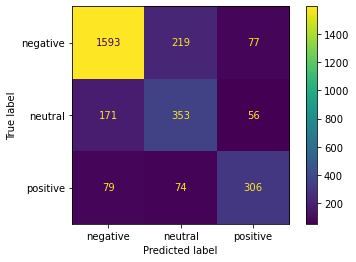

In [47]:
from sklearn.metrics import plot_confusion_matrix

# Number of classes in our test set
print(y_test.value_counts())

plot_confusion_matrix(clf, X_test, y_test) 

The diagonal (1593, 353, 306) shows the number of tweets our model was able to correctly predict. The first row shows that we correctly classified 1593 tweets as being negative, and incorreclty classified 219 to be neutral and 77 to be negative. The second row shows that our model correclty classified 353 tweets as neutral, 171 neutral as being negative and 56 as being positive. The third row shows that we correclty classified 306 tweets as being positive, incorreclty classified 74 positive tweets as being neutral and 79 as negative. 

### 3. Run a MultiomialNB to classify sentiment
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [48]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [49]:
y_pred = clf.predict(X_test)

In [50]:
clf.score(X_test, y_test)

0.7517076502732241

In [51]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
                            target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.81      0.88      0.84      1889
     neutral       0.54      0.42      0.48       580
    positive       0.70      0.65      0.67       459

    accuracy                           0.75      2928
   macro avg       0.68      0.65      0.66      2928
weighted avg       0.74      0.75      0.74      2928



### 4. Run a MultinomialNB to classify sentiment, but instead of using a count vector you should use a TF-IDF-vector for each instance.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(df['text']).toarray()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [87]:
y_pred = clf.predict(X_test)

In [88]:
clf.score(X_test, y_test)

0.7459016393442623

In [89]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred,
                            target_names=["negative", "neutral", "positive"]))

              precision    recall  f1-score   support

    negative       0.74      0.97      0.84      1889
     neutral       0.69      0.25      0.37       580
    positive       0.83      0.44      0.58       459

    accuracy                           0.75      2928
   macro avg       0.75      0.56      0.60      2928
weighted avg       0.74      0.75      0.71      2928

